# Initialization and Imports

In [1]:
%load_ext dotenv
%dotenv
import os
import math

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['WANDB_NOTEBOOK_NAME'] = 'diffusion experiments.ipynb'

In [2]:
import tensorflow as tf
import jax.numpy as np
import time
import matplotlib.pyplot as plt
import cv2
from keras.utils import (
    to_categorical,
)  # Only for categorical one hot encoding
from sklearn.metrics import accuracy_score
import tensorflow_datasets as tfds
import tensorboard
import keras
from keras import layers
from tensorflow_datasets.core.utils import gcs_utils
import os

gcs_utils._is_gcs_disabled = True
import datetime
from IPython.display import clear_output
import tqdm
import pickle
import timeit

2024-05-22 15:53:18.172737: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 15:53:18.200983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 15:53:18.640068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mrwhite0racle/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
s_wandb_available = False
try:
    import wandb
    from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

    is_wandb_available = True
except Exception as e:
    print("Wandb not available")
    print(e)

# !rm -rf ./logs/
RANDOM_SEED = 42
MODEL_NAME = "DiffusionExperiments"

try:
    from google.colab import drive

    drive.mount("/content/gdrive")
    MODEL_PATH = os.path.join(
        "/content/gdrive/My Drive/AI Research/diffusion/models/", MODEL_NAME
    )
except Exception as e:
    MODEL_PATH = os.path.join("models", MODEL_NAME)

TRAIN_LOGDIR = os.path.join(
    "logs", "tensorflow", MODEL_NAME
)  # Sets up a log directory.
# Make sure these directories exist
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(TRAIN_LOGDIR, exist_ok=True)
# Start a profiler server before your model runs.
tf.profiler.experimental.server.start(6009)

2024-05-22 15:53:20.311684: I external/local_tsl/tsl/profiler/rpc/profiler_server.cc:46] Profiler server listening on [::]:6009 selected port:6009


In [4]:
# Some Optimizations
import ctypes

_libcudart = ctypes.CDLL("libcudart.so")
# Set device limit on the current device
# cudaLimitMaxL2FetchGranularity = 0x05
pValue = ctypes.cast((ctypes.c_int * 1)(), ctypes.POINTER(ctypes.c_int))
_libcudart.cudaDeviceSetLimit(ctypes.c_int(0x05), ctypes.c_int(128))
_libcudart.cudaDeviceGetLimit(pValue, ctypes.c_int(0x05))
assert pValue.contents.value == 128
tf.compat.v1.ConfigProto.force_gpu_compatible = True

keras.config.set_image_data_format("channels_last")

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-05-22 15:53:20.380668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-22 15:53:20.403107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-22 15:53:20.403249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
# precision_policy = keras.mixed_precision.Policy('mixed_float16')
precision_policy = keras.mixed_precision.Policy("float32")
keras.mixed_precision.set_global_policy(precision_policy)
tf.keras.mixed_precision.set_global_policy(precision_policy)

tf.debugging.set_log_device_placement(True)

# Utilities

In [6]:
normalizeImage = lambda x: tf.divide(
    tf.subtract(tf.cast(x, dtype=precision_policy.compute_dtype), 127.5), 127.5
)
denormalizeImage = lambda x: tf.cast(
    tf.add(tf.multiply(x, 127.5), 127.5), dtype=tf.uint8
)

l2normalizeImage = lambda x: tf.math.l2_normalize(x)


def plotImages(imgs):
    fig = plt.figure(figsize=(8, 8))

    for i in range(imgs.shape[0]):
        plt.subplot(8, 8, i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

In [7]:
@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, image_size, kid_image_size, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = keras.ops.cast(keras.ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ keras.ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = keras.ops.cast(batch_size, dtype="float32")
        mean_kernel_real = keras.ops.sum(kernel_real * (1.0 - keras.ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = keras.ops.sum(
            kernel_generated * (1.0 - keras.ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = keras.ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

# Data Pipeline

In [8]:
def get_dataset(data_name="celeb_a", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], precision_policy.compute_dtype) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)
            return {"image": image}

        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        # .prefetch(tf.data.experimental.AUTOTUNE)
        # .batch(128, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .cache()  # Cache after augmenting to avoid recomputation
        # .unbatch()
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .repeat()  # Repeats the dataset indefinitely
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return final_data, len(data)

# Diffusion Schedulers

In [17]:
class DiffusionSchedule:
    def __init__(self, timesteps, *args, **kwargs):
        self.timesteps = timesteps

    def add_noise(self, images, t, noise):
        raise NotImplementedError

    def remove_all_noise(self, noisy_images, t, noise):
        raise NotImplementedError
    
    def sample_step(self, pred_noise, x, t, clip_denoised=True):
        raise NotImplementedError


class DDPMSchedule(DiffusionSchedule):
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = self._linear_beta_schedule(timesteps, beta_start, beta_end)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = tf.math.cumprod(self.alphas)

    def _linear_beta_schedule(self, timesteps, beta_start, beta_end):
        return tf.linspace(beta_start, beta_end, timesteps)

    def add_noise(self, images, t, noise):
        sqrt_alpha_bars_t = tf.sqrt(tf.gather(self.alpha_bars, t))
        sqrt_alpha_bars_t = tf.reshape(sqrt_alpha_bars_t, [-1, 1, 1, 1])
        sqrt_one_minus_alpha_bars_t = tf.sqrt(1.0 - tf.gather(self.alpha_bars, t))
        sqrt_one_minus_alpha_bars_t = tf.reshape(
            sqrt_one_minus_alpha_bars_t, [-1, 1, 1, 1]
        )
        return sqrt_alpha_bars_t * images + sqrt_one_minus_alpha_bars_t * noise

    def remove_all_noise(self, noisy_images, t, noise, remove_steps=1):
        # Remove all noise in one step
        # This is the reverse of the add_noise operation
        sqrt_alpha_bars_t = tf.sqrt(tf.gather(self.alpha_bars, t))
        sqrt_alpha_bars_t = tf.reshape(sqrt_alpha_bars_t, [-1, 1, 1, 1])
        sqrt_one_minus_alpha_bars_t = tf.sqrt(1.0 - tf.gather(self.alpha_bars, t))
        sqrt_one_minus_alpha_bars_t = tf.reshape(
            sqrt_one_minus_alpha_bars_t, [-1, 1, 1, 1]
        )
        clean_images = (noisy_images - sqrt_one_minus_alpha_bars_t * noise) / sqrt_alpha_bars_t
        return clean_images

    def sample_step(self, predicted_noise, noisy_images, t, clip_denoised=True):
        alpha_t = tf.gather(self.alphas, t)
        beta_t = tf.gather(self.betas, t)
        alpha_bar_t = tf.gather(self.alpha_bars, t)
        one_minus_alpha_bar_t = 1.0 - alpha_bar_t

        alpha_t = tf.reshape(alpha_t, [-1, 1, 1, 1])
        beta_t = tf.reshape(beta_t, [-1, 1, 1, 1])
        alpha_bar_t = tf.reshape(alpha_bar_t, [-1, 1, 1, 1])
        one_minus_alpha_bar_t = tf.reshape(one_minus_alpha_bar_t, [-1, 1, 1, 1])

        # Compute the posterior mean and variance
        posterior_mean_coeff1 = 1 / tf.sqrt(alpha_t)
        posterior_mean_coeff2 = beta_t / tf.sqrt(1.0 - alpha_bar_t)

        mean = posterior_mean_coeff1 * (
            noisy_images - posterior_mean_coeff2 * predicted_noise
        )
        variance = (1 - alpha_t) / (1 - alpha_bar_t)

        noise = tf.random.normal(shape=noisy_images.shape, mean=0.0, stddev=1.0)
        noisy_images = mean + tf.sqrt(variance) * noise

        t = tf.maximum(t - 1, 0)

        return noisy_images


class GaussianDiffusion(DiffusionSchedule):
    def __init__(
        self,
        timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        clip_min=-1.0,
        clip_max=1.0,
    ):
        super().__init__(timesteps)
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

    def _extract(self, a, t, x_shape):
        """Extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.

        Args:
            a: Tensor to extract from
            t: Timestep for which the coefficients are to be extracted
            x_shape: Shape of the current batched samples
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Extracts the mean, and the variance at current timestep.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Diffuse the data.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
            noise: Gaussian noise to be added at the current timestep
        Returns:
            Diffused samples at timestep `t`
        """
        x_start_shape = tf.shape(x_start)
        clean_images = (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
        )
        noisy_images = (
            self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape) * noise
        )
        return clean_images + noisy_images

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

    def sample_step(self, pred_noise, x, t, clip_denoised=True):
        return self.p_sample(pred_noise, x, t, clip_denoised)

    def add_noise(self, images, t, noise):
        return self.q_sample(images, t, noise)

    def remove_noise(self, noisy_images, t, noise):
        # This is the reverse of the add_noise operation
        clean_images = self.predict_start_from_noise(noisy_images, t, noise)
        return clean_images

2024-05-22 16:11:42.480212: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


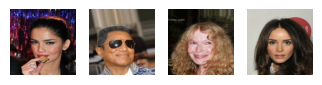

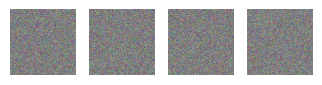

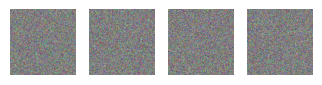

In [20]:
# Visualize adding some noise to some sample images and then removing it
data, _ = get_dataset("celeb_a", batch_size=4, image_scale=256)
images = next(iter(data))["image"]
plotImages(images)
noise_level = 500 * tf.ones(shape=(4,), dtype=tf.int64)
noise_level_max = 1000
schedule = GaussianDiffusion(timesteps=noise_level_max)
noise = tf.random.normal(shape=images.shape)
noisy_images = schedule.add_noise(images, noise_level, noise)
plotImages(noisy_images)
plotImages(noise)

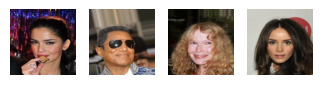

In [21]:
reconstructed_images = schedule.remove_noise(noisy_images, noise_level, noise)
plotImages(reconstructed_images)

# Modeling

In [22]:
@keras.saving.register_keras_serializable()
class PixelReshuffle(keras.Layer):
    def __init__(self, upscale_factor, **kwargs):
        super(PixelReshuffle, self).__init__(**kwargs)
        self.upscale_factor = upscale_factor

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.upscale_factor)

    def compute_output_shape(self, input_shape):
        height, width, channels = input_shape[1], input_shape[2], input_shape[3]
        new_height = height * self.upscale_factor
        new_width = width * self.upscale_factor
        new_channels = channels // (self.upscale_factor**2)
        return (input_shape[0], new_height, new_width, new_channels)

    def get_config(self):
        config = super(PixelReshuffle, self).get_config()
        config.update({"upscale_factor": self.upscale_factor})
        return config


# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )


class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj

In [27]:
class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb


def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply


def residual_block(
    x, t, features, kernel_size, strides, padding, activation, direction, res, groups=8
):
    x = layers.SeparableConv2D(
        features,
        kernel_size,
        strides=strides,
        padding=padding,
        name=f"{direction}_{res}_conv1",
        depthwise_initializer=kernel_init(1.0),
        pointwise_initializer=kernel_init(1.0),
    )(x)
    temb = layers.Activation(activation, name=f"{direction}_{res}_temb_act1")(t)
    temb = layers.Dense(features, kernel_initializer=kernel_init(1.0))(temb)[
        :, None, None, :
    ]
    x = layers.Add()([x, temb])
    x = layers.GroupNormalization(groups=groups, name=f"{direction}_{res}_bn1")(x)
    x = layers.Activation(activation, name=f"{direction}_{res}_act1")(x)

    x = layers.SeparableConv2D(
        features,
        kernel_size,
        strides=strides,
        padding=padding,
        name=f"{direction}_{res}_conv2",
        depthwise_initializer=kernel_init(1.0),
        pointwise_initializer=kernel_init(1.0),
    )(x)
    x = layers.GroupNormalization(groups=groups, name=f"{direction}_{res}_bn2")(x)
    x = layers.Activation(activation, name=f"{direction}_{res}_act2")(x)
    return x


def generate_unet(
    input_shape,
    activation_fn=keras.activations.mish,
    norm_groups=8,
):
    # Generate a unet model with residual connections
    inputs = keras.Input(shape=input_shape, name="input")
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")
    res = input_shape[1]
    x = inputs
    feature_depths = [64, 128, 256, 512]
    should_use_attention = [False, False, True, True]

    temb = TimeEmbedding(dim=feature_depths[0] * 4)(time_input)
    temb = TimeMLP(units=feature_depths[0] * 4, activation_fn=activation_fn)(temb)

    downsample_layers = []
    for features, should_attention in zip(feature_depths, should_use_attention):
        x = residual_block(
            x,
            temb,
            features,
            5,
            1,
            "same",
            activation=activation_fn,
            direction="down",
            res=res,
            groups=norm_groups,
        )
        if should_attention:
            x = AttentionBlock(features, groups=norm_groups)(x)
        downsample_layers.append(x)
        x = layers.AveragePooling2D(2, name=f"downsample_{res}")(x)
        # x = layers.SeparableConv2D(
        #     features, 3, strides=2, 
        #     padding="same", name=f"downsample_{res}",
        #     depthwise_initializer=kernel_init(1.0),
        #     pointwise_initializer=kernel_init(1.0),
        # )(x)
        res = res // 2

    x = layers.SeparableConv2D(
        1024, 
        3, 
        strides=1, 
        padding="same", 
        name="middle_conv1",
        depthwise_initializer=kernel_init(1.0),
        pointwise_initializer=kernel_init(1.0),
    )(x)
    x = layers.GroupNormalization(name="middle_bn1", groups=norm_groups)(x)
    x = layers.Activation(activation_fn, name="middle_act1")(x)
    # x = AttentionBlock(1024, groups=norm_groups)(x)
    x = PixelReshuffle(2, name="middle_upsample")(x)

    upsample_layers = []
    for features, should_attention in zip(reversed(feature_depths), reversed(should_use_attention)):
        downsample = downsample_layers.pop()
        x = layers.Concatenate()([x, downsample])
        x = residual_block(
            x,
            temb,
            features,
            5,
            1,
            "same",
            activation=activation_fn,
            direction="up",
            res=res,
            groups=norm_groups,
        )
        if should_attention:
            x = AttentionBlock(features, groups=norm_groups)(x)
        if features != 64:
            x = PixelReshuffle(2, name=f"upsample_{res}")(x)
        upsample_layers.append(x)
        res = res * 2

    x = layers.Conv2D(
        3, 3, 
        strides=1, 
        padding="same", 
        # activation="tanh", 
        name="output",
        kernel_initializer=kernel_init(0.0)
    )(x)
    model = keras.Model(inputs=[inputs, time_input], outputs=x)
    return model


class VisionDiffusion(keras.Model):
    def __init__(self, image_scale=256, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Define an autoencoder model
        self.model = generate_unet([image_scale, image_scale, 3])
        self.image_scale = image_scale
        self.train_step_counter = tf.Variable(0, dtype=tf.int64, trainable=False)

    def compile(self, optimizer, loss_fn, schedule: DiffusionSchedule, 
                *args, **kwargs):
        super().compile(*args, **kwargs)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.schedule = schedule
        self.kid_metric = KID(name="kid", image_size=self.image_scale, kid_image_size=75)
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid_metric]

    @tf.function(jit_compile=True)
    def train_step(self, data):
        self.train_step_counter.assign_add(1)
        clean_images = data["image"]
        # 1. Get the batch size
        batch_size = tf.shape(clean_images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0,
            maxval=self.schedule.timesteps,
            shape=(batch_size,),
            dtype=tf.int64,
        )
        # Generate a sample noise from our noise schedule
        # We need to predict the noise in the noisy image which
        # we can then subtract from the noisy image to get the clean image
        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=clean_images.shape, dtype=clean_images.dtype)
            noisy_images = self.schedule.add_noise(clean_images, t, noise)

            noise_prediction = self.model([noisy_images, t], training=True)

            # Normalize the clean image
            n_loss = self.loss_fn(noise, noise_prediction) 
            # n_loss *= (tf.cast(t, tf.float32)) #/self.schedule.timesteps
        gradients = tape.gradient(n_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

        self.noise_loss_tracker.update_state(n_loss)
        # self.image_loss_tracker.update_state(i_loss)

        return {
            "loss": n_loss,
            # "image_loss": i_loss,
        }

    # @tf.function(jit_compile=True)
    def generate_images(self, num_images=16):
        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, self.image_scale, self.image_scale, 3), dtype=tf.float32
        )
        # 2. Sample from the model iteratively
        for t in tqdm.tqdm(reversed(range(0, self.schedule.timesteps))):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.model.predict(
                [samples, tt], verbose=0, batch_size=num_images
            )
            samples = self.schedule.sample_step(pred_noise, samples, tt, clip_denoised=True)
            # samples = self.schedule.p_sample(pred_noise, samples, tt, clip_denoised=True)
        # 3. Return generated samples
        return samples

In [ ]:
unet = generate_unet((64, 64, 3))
unet.summary()
# # Plot the model
keras.utils.plot_model(
    unet,
    expand_nested=True,
    show_shapes=True,
    show_layer_names=True,
    dpi=96,
    show_trainable=True,
)

In [28]:
class Monitor(keras.callbacks.Callback):
    metrics_description_table = {
        "loss": "Training Loss",
        "kid_score": "KID Score",
    }
    def __init__(
        self,
        batch_size=64,
        tf_logdir="./logs/tensorflow",
    ):
        super().__init__()
        self.batch_size = batch_size
        self.tf_writer = tf.summary.create_file_writer(os.path.join(tf_logdir, 'train'))

    def on_batch_end(self, batch, logs):
        if tf.math.mod(batch, 100) == 0:
            with self.tf_writer.as_default():
                for metric, value in logs.items():
                    better_key = self.metrics_description_table.get(metric, metric)
                    tf.summary.scalar(better_key, value, step=self.model.train_step_counter)
        

# Training Pipeline

In [29]:
IMAGE_SCALE = 64
BATCH_SIZE = 32

diffusion_model = VisionDiffusion(IMAGE_SCALE)
diffusion_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-4),
    loss_fn=keras.losses.MeanSquaredError(),
    schedule=GaussianDiffusion(timesteps=1000),
)
experiment_name = "{name}_{date}".format(
    name=MODEL_NAME, date=datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
)
log_dir = os.path.join(TRAIN_LOGDIR, experiment_name)
# os.system("rm -rf ./{log_dir}".format(log_dir=TRAIN_LOGDIR))

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    update_freq="epoch",
    write_images=True,
    write_graph=True,
    histogram_freq=1,
)

monitor = Monitor(tf_logdir=log_dir)

In [30]:
# Load the CelebA dataset
data, dateLen = get_dataset("celeb_a", batch_size=BATCH_SIZE, image_scale=IMAGE_SCALE)

# Train the model
diffusion_model.fit(
    data, epochs=20, batch_size=BATCH_SIZE, steps_per_epoch=dateLen // BATCH_SIZE,
    callbacks=[tensorboard_callback, monitor],
)

Epoch 1/20


In [16]:
model = diffusion_model.model

0it [00:00, ?it/s]I0000 00:00:1716374786.517158    9841 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1716374786.771187    9847 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716374786.914814    9845 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_32', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716374786.969513    9856 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_32', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1716374789.449987    5230 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 48 bytes spill stores, 48 bytes spill loads

1000it [00:37, 26.53it/s

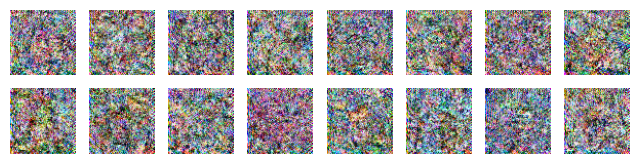

In [26]:
diffusion_model.model = model
imgs = diffusion_model.generate_images(16)
plotImages(imgs)